A well-chosen initialization can:

- Speed up the convergence of gradient descent.
- Increase the odds of gradient descent converging to a lower training (and generalization) error.

Let's get started!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import h5py
%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'



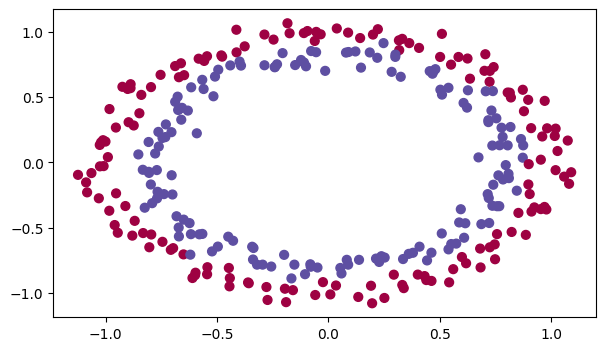

In [2]:
# load image dataset: blue/red dots in circles
def load_dataset():
    np.random.seed(1)
    train_X, train_Y = sklearn.datasets.make_circles(n_samples=300, noise=.05)
    np.random.seed(2)
    test_X, test_Y = sklearn.datasets.make_circles(n_samples=100, noise=.05)
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    test_X = test_X.T
    test_Y = test_Y.reshape((1, test_Y.shape[0]))
    return train_X, train_Y, test_X, test_Y
    
train_X, train_Y, test_X, test_Y = load_dataset()

These are the initialization methods we'll experiment with:

Zeros initialization -- setting initialization = "zeros" in the input argument.
Random initialization -- setting initialization = "random" in the input argument. This initializes the weights to large random values.
He initialization -- setting initialization = "he" in the input argument. This initializes the weights to random values scaled according to a paper by He et al., 2015.

In [9]:
#Let`s first import all helper functions
def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    """
    Compute the relu of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- relu(x)
    """
    s = np.maximum(0,x)
    
    return s

def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
        
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3) = cache
    
    dz3 = 1./m * (a3 - Y)
    dW3 = np.dot(dz3, a2.T)
    db3 = np.sum(dz3, axis=1, keepdims = True)
    
    da2 = np.dot(W3.T, dz3)
    dz2 = np.multiply(da2, np.int64(a2 > 0))
    dW2 = np.dot(dz2, a1.T)
    db2 = np.sum(dz2, axis=1, keepdims = True)
    
    da1 = np.dot(W2.T, dz2)
    dz1 = np.multiply(da1, np.int64(a1 > 0))
    dW1 = np.dot(dz1, X.T)
    db1 = np.sum(dz1, axis=1, keepdims = True)
    
    gradients = {"dz3": dz3, "dW3": dW3, "db3": db3,
                 "da2": da2, "dz2": dz2, "dW2": dW2, "db2": db2,
                 "da1": da1, "dz1": dz1, "dW1": dW1, "db1": db1}
    
    return gradients

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of n_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters['W' + str(i)] = ... 
                  parameters['b' + str(i)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(L):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

def compute_loss(a3, Y):
    
    """
    Implement the loss function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    loss - value of the loss function
    """
    
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    loss = 1./m * np.nansum(logprobs)
    
    return loss

def load_cat_dataset():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    train_set_x_orig = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
    test_set_x_orig = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
    
    train_set_x = train_set_x_orig/255
    test_set_x = test_set_x_orig/255

    return train_set_x, train_set_y, test_set_x, test_set_y, classes


def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = int)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

In [10]:

#Lets define the model
def model(X, Y, learning_rate = 0.01, num_iterations = 15000, print_cost = True, initialization = "he"):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.

    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (containing 0 for red dots; 1 for blue dots), of shape (1, number of examples)
    learning_rate -- learning rate for gradient descent
    num_iterations -- number of iterations to run gradient descent
    print_cost -- if True, print the cost every 1000 iterations
    initialization -- flag to choose which initialization to use ("zeros","random" or "he")

    Returns:
    parameters -- parameters learnt by the model
    """

    grads = {}
    costs = [] # to keep track of the loss
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 10, 5, 1]

    # Initialize parameters dictionary.
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)

    # Loop (gradient descent)

    for i in range(num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        a3, cache = forward_propagation(X, parameters)

        # Loss
        cost = compute_loss(a3, Y)

        # Backward propagation.
        grads = backward_propagation(X, Y, cache)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)

    # plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

    return parameters

In [11]:
#initialize with Paramaters with zero

def initialize_parameters_zeros(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.

    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """

    parameters = {}
    L = len(layers_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.zeros((layers_dims[l], layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters

In [12]:
parameters = initialize_parameters_zeros([3, 2, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[0. 0. 0.]
 [0. 0. 0.]]
b1 = [[0.]
 [0.]]
W2 = [[0. 0.]]
b2 = [[0.]]


Cost after iteration 0: 0.6931471805599453
Cost after iteration 1000: 0.6931471805599453
Cost after iteration 2000: 0.6931471805599453
Cost after iteration 3000: 0.6931471805599453
Cost after iteration 4000: 0.6931471805599453
Cost after iteration 5000: 0.6931471805599453
Cost after iteration 6000: 0.6931471805599453
Cost after iteration 7000: 0.6931471805599453
Cost after iteration 8000: 0.6931471805599453
Cost after iteration 9000: 0.6931471805599453
Cost after iteration 10000: 0.6931471805599453
Cost after iteration 11000: 0.6931471805599453
Cost after iteration 12000: 0.6931471805599453
Cost after iteration 13000: 0.6931471805599453
Cost after iteration 14000: 0.6931471805599453


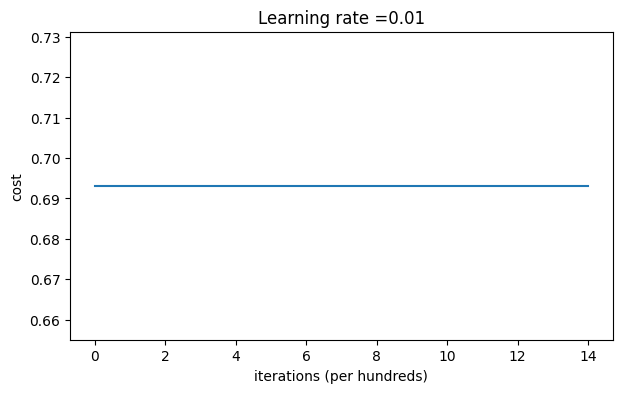

On the train set:
Accuracy: 0.5
On the test set:
Accuracy: 0.5


In [13]:
#Now lets train the model to test it out
parameters = model(train_X, train_Y, initialization = "zeros")
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)


The performance is terrible, the cost doesn't decrease, and the algorithm performs no better than random guessing. 
Why? Take a look at the details of the predictions and the decision boundary:

In [14]:
print ("predictions_train = " + str(predictions_train))
print ("predictions_test = " + str(predictions_test))

predictions_train = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0]]
predictions_test = [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


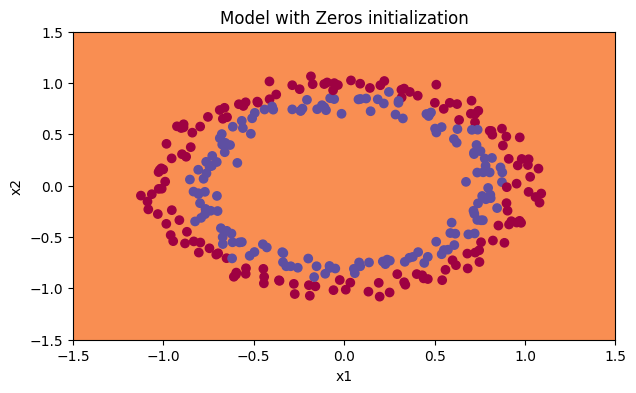

In [15]:
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Since the weights and biases are zero, multiplying by the weights creates the zero vector which gives 0 when the activation function is ReLU. As z = 0
As for every example you are getting a 0.5 chance of it being true our cost function becomes helpless in adjusting the weights.This is why you can see that the model is predicting 0 for every example! No wonder it's doing so badly.

In general, initializing all the weights to zero results in the network failing to break symmetry. This means that every neuron in each layer will learn the same thing, so you might as well be training a neural network with  𝑛[𝑙]=1
for every layer. This way, the network is no more powerful than a linear classifier like logistic regression.

In [16]:
#Random Initialization
def initialize_parameters_random(layers_dims):

    np.random.seed(3)               # This seed makes sure your "random" numbers will be the as mine
    parameters = {}
    L = len(layers_dims)            # integer representing the number of layers

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
    return parameters

In [17]:
parameters = initialize_parameters_random([2, 4, 1])
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 0.01788628  0.0043651 ]
 [ 0.00096497 -0.01863493]
 [-0.00277388 -0.00354759]
 [-0.00082741 -0.00627001]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[-0.00043818 -0.00477218 -0.01313865  0.00884622]]
b2 = [[0.]]
